In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np

2022-06-23 13:13:50.434985: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [107]:
# image_size = (1024+512, 1024+512)
# model = tf.keras.models.load_model('best_models/oversample_original_F1_095.h5', custom_objects={'AdamW': tfa.optimizers.AdamW})

image_size = (64+128, 64+128)
model = tf.keras.models.load_model('best_models/128x128/oversample_model_f1_085.h5', custom_objects={'AdamW': tfa.optimizers.AdamW})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Augment_and_Crop_and_Rescale (S (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    224         Augment_and_Crop_and_Rescale[0][0
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 8)    32          conv2d[0][0]                     
______________________________________________________________________________________________

In [142]:
##### Model on smaller img res ####

# False Negatives
# path = "/home/filippo/data/polar_low/test/pos/"
# img_name = "cb7c73_20200515T113021_20200515T113126_mos_rgb.png"
# img_name = "e4ecea_20200803T112425_20200803T112540_mos_rgb.png"
# img_name = "ec02c1_20171216T103356_20171216T103555_mos_rgb.png"
# img_name = "ec0d39_20181229T080453_20181229T080621_mos_rgb.png"
# img_name = "ecc879_20201204T041136_20201204T041341_mos_rgb.png"
# img_name = "f3e78b_20181103T184809_20181103T184924_mos_rgb.png"
# img_name = "f3f01c_20201223T070828_20201223T070926_mos_rgb.png"
# img_name = "f8dba3_20180117T143557_20180117T143801_mos_rgb.png"
# img_name = "ff3721_20171228T085625_20171228T085714_mos_rgb.png"

# False Positives
path = "/home/filippo/data/polar_low/test/neg/"
# img_name = "cca544_20150915T062552_20150915T062756_mos_rgb.png"
# img_name = "cca544_20151009T062553_20151009T062757_mos_rgb.png"
# img_name = "d47404_20180927T162737_20180927T162852_mos_rgb.png"
img_name = "d9d7e0_20200114T181051_20200114T181251_mos_rgb.png"
# img_name = "e51fe1_20190506T043022_20190506T043142_mos_rgb.png"

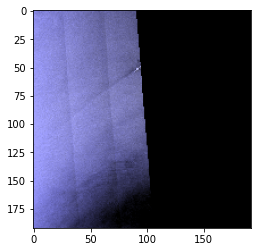

In [143]:
# Load image to test

# path = "/home/filippo/data/polar_low/results/FN/"


# False Positives
# img_name = "f850aa_20160219T085536_20160219T085716_mos_rgb.png"

# False Negatives
# img_name = "cca544_20150927T062553_20150927T062657_mos_rgb.png"
# img_name = "d9d7e0_20200102T181051_20200102T181251_mos_rgb.png"
# img_name = "ec02c1_20171216T103356_20171216T103555_mos_rgb.png"
# img_name = "f850aa_20160126T085536_20160126T085716_mos_rgb.png"
# img_name = "ff3721_20171228T085625_20171228T085714_mos_rgb.png"

# True positives
# img_name = "cac66d_20190731T034721_20190731T034910_mos_rgb.png"
# img_name = "cb7c73_20200515T113021_20200515T113126_mos_rgb.png"
# img_name = "cffe42_20191012T084028_20191012T084212_mos_rgb.png"
# img_name = "d1996d_20200406T190715_20200406T190819_mos_rgb.png"
# img_name = "f06932_20151211T163926_20151211T164030_mos_rgb.png"
# img_name = "f414c2_20181226T055833_20181226T060006_mos_rgb.png"

img = keras.preprocessing.image.load_img(
    path + img_name, 
    target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

plt.imshow(img)

In [144]:
preds = model.predict(img_array)
print(preds)
print(model.layers[-1].activation)

[[0.57837576 0.4216242 ]]
None


grads: (1, 8, 8, 64)
-0.085353866 0.12442741
pooled_grads: (64,)
-0.0017253052 0.0043335897
last_conv_layer_output: (1, 8, 8, 64)
heatmap: (8, 8, 1)
-0.00030687812 0.036452066


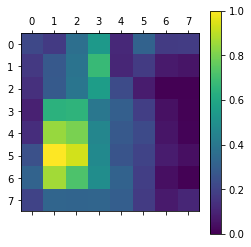

In [145]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Since the model has Dropout and image augmentation layers, 
        # we need to disable them to compute the gradients by setting training=False
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print("pred_index: ", pred_index)
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print("grads:", grads.shape)
    print(grads.numpy().min(), grads.numpy().max())

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # probably each feature in the 8x8 grid has the same value and it would have been enough to take just 1 slice rather than the mean.
    print("pooled_grads:",pooled_grads.shape)
    print(pooled_grads.numpy().min(), pooled_grads.numpy().max())
    print("last_conv_layer_output:",last_conv_layer_output.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    print("heatmap:", heatmap.shape)
    print(heatmap.numpy().min(), heatmap.numpy().max())
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Remove last layer's activation (softmax or sigmoid)
model.layers[-1].activation = None

# Since the model has Dropout and image augmentation layers, we need to disable them to compute the gradients by setting training=False
tf.keras.backend.set_learning_phase(0)

# last_conv_layer_name = 'activation_14' # This is for the HR model
last_conv_layer_name = 'activation_8' # this is for the Low-res model
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=1)

plt.matshow(heatmap)
plt.colorbar()
plt.show()

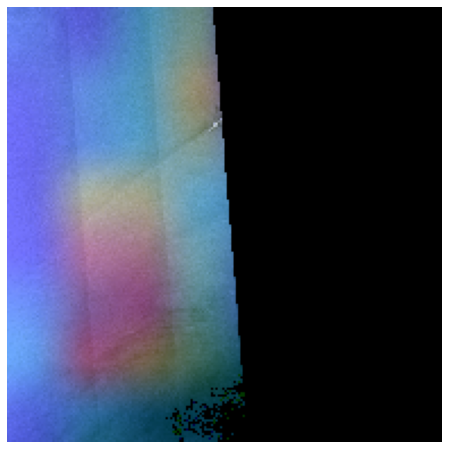

In [146]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    
    jet_heatmap[img==0] = 0
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap*0.4 + img 
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(superimposed_img)
    ax.axis("off")
#     plt.title("Grad-CAM")
    plt.show()

numpy_img = np.uint8(img_array[0].numpy())
# numpy_img = numpy_img[256:-256, 256:-256]

display_gradcam(numpy_img, heatmap)